### Imports

In [1]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import os
import math
import pickle
import datetime
import heapq
import xgboost as xgb
import h5py
from tqdm import tqdm_notebook as tqdm

from keras import backend as K
from keras.models import Model, load_model
from keras.layers import Dense, Activation, Conv2D, MaxPooling2D, Reshape, Lambda, ZeroPadding2D, GaussianNoise, AlphaDropout, Input, Concatenate
from keras.layers.core import Flatten, Dropout
from keras.optimizers import Adam, SGD
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau, LearningRateScheduler
from keras.utils import to_categorical, normalize
from keras.models import model_from_json
from keras_tqdm import TQDMNotebookCallback

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import metrics
import tensorflow as tf

from scipy import ndimage
from skimage.morphology import reconstruction
from skimage.restoration import denoise_wavelet, denoise_tv_chambolle, denoise_nl_means

from cyclicLR_callback import CyclicLR

random_seed = 54321
np.random.seed(random_seed)
cwd = os.getcwd()
#for windows
model_path = cwd + '\\models\\'

D:\Anaconda3\envs\tf-gpu\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
Using TensorFlow backend.


In [2]:
import keras
keras.__version__

'2.1.2'

Manually create tensorflow session to avoid potential OEM errors on laptop's GPU.

In [3]:
tf.set_random_seed(random_seed)
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)
K.set_session(session)
K.set_image_dim_ordering('tf')

In [4]:
!nvidia-smi

'nvidia-smi' is not recognized as an internal or external command,
operable program or batch file.


### Load Data

In [10]:
data = pd.read_json("Data/train/train.json", orient='records')
data.head()
train_df = data

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1604 entries, 0 to 1603
Data columns (total 5 columns):
band_1        1604 non-null object
band_2        1604 non-null object
id            1604 non-null object
inc_angle     1604 non-null object
is_iceberg    1604 non-null int64
dtypes: int64(1), object(4)
memory usage: 62.7+ KB


### Missing values

In [12]:
train_df['inc_angle_f'] = pd.to_numeric(train_df['inc_angle'], errors='coerce')
print("missing values in inc_angle: ", train_df['inc_angle_f'].isnull().sum())
#train_df['inc_angle_f'].replace(np.nan,train_df['inc_angle_f'].mean(), inplace=True)
train_df['inc_angle_f'].replace(np.nan,0, inplace=True)
train_df.tail()

missing values in inc_angle:  133


,band_1,band_2,id,inc_angle,is_iceberg,inc_angle_f
1599,"[-30.999878, -29.976866, -28.233906, -29.50732...","[-27.847719, -28.233864, -24.712077999999998, ...",04e11240,na,0,0.0
1600,"[-25.31155, -26.511555, -28.694487, -27.180115...","[-29.563713, -28.290375, -26.839405, -28.29046...",c7d6f6f8,na,0,0.0
1601,"[-18.141895, -18.141844, -19.01737, -19.701599...","[-25.305355, -29.387701, -28.963863, -26.16023...",bba1a0f1,na,0,0.0
1602,"[-22.455633, -25.794661, -26.954567, -22.83354...","[-26.070356, -22.093737, -21.577662, -24.53376...",7f66bb44,na,0,0.0
1603,"[-19.909191, -20.678406, -20.208834, -18.42441...","[-24.44487, -24.956001, -27.722103, -26.078417...",9d8f326c,na,0,0.0


### Transform for NN

In [13]:
def get_bands(train_df):
    max_col = np.array(train_df.apply(lambda x: max((max(train_df.loc[x.name,'band_1']),max(train_df.loc[x.name,'band_2']))),axis=1)) - 10
    max_col2 = max_col.reshape(-1,1) * np.ones(75*75).reshape(1,75*75)
    max_col2 = max_col2.reshape(-1,75,75)

    band_1 = np.array(train_df['band_1'].tolist()).reshape(-1,75,75) - max_col2
    band_2 = np.array(train_df['band_2'].tolist()).reshape(-1,75,75) - max_col2
    band_1_t = 10**(band_1/10)
    band_2_t = 10**(band_2/10)
    band_1_t = np.where(band_1_t > 0.01, band_1_t, 0)
    band_2_t = np.where(band_2_t > 0.01, band_2_t, 0)
    band_3 = band_1_t - band_2_t
    X = np.stack((band_1,band_2,band_1_t,band_2_t),axis=3)
    
    return band_1, band_2, band_1_t, band_2_t, band_3, X

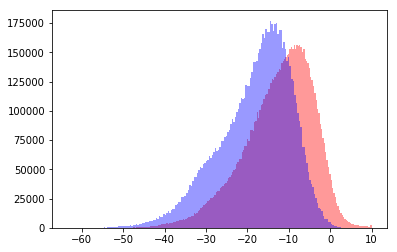

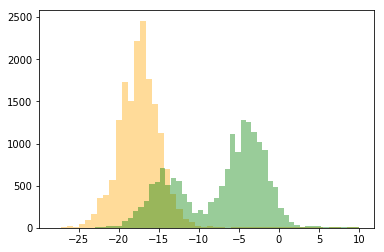

In [14]:
band_1, band_2, band_1_t, band_2_t, band_3, X = get_bands(train_df)
plt.hist(band_1.flatten(), bins=200, color="red", alpha=0.4)
plt.hist(band_2.flatten(), bins=200, color="blue", alpha=0.4)
plt.show()

plt.hist(band_1[train_df[train_df['is_iceberg']==0].index[:3]].flatten(), bins=50, color="orange", alpha=0.4)
plt.hist(band_1[train_df[train_df['is_iceberg']==1].index[:3]].flatten(), bins=50, color="green", alpha=0.4)
plt.show()

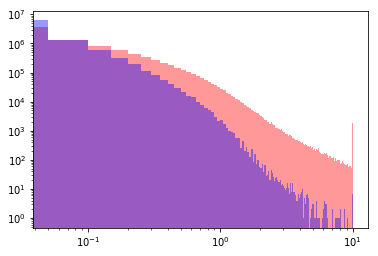

In [15]:
plt.hist(band_1_t.flatten(),bins=200, color="red", alpha=0.4)
plt.hist(band_2_t.flatten(),bins=200, color="blue", alpha=0.4)
plt.yscale('log')
plt.xscale('log')
plt.show()

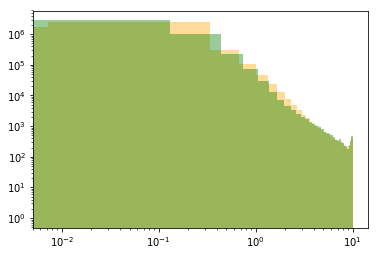

In [16]:
plt.hist(band_3[train_df[train_df['is_iceberg']==0].index].flatten(), bins=50, color="orange", alpha=0.4)
plt.hist(band_3[train_df[train_df['is_iceberg']==1].index].flatten(), bins=50, color="green", alpha=0.4)
plt.yscale('log')
plt.xscale('log')
plt.show()

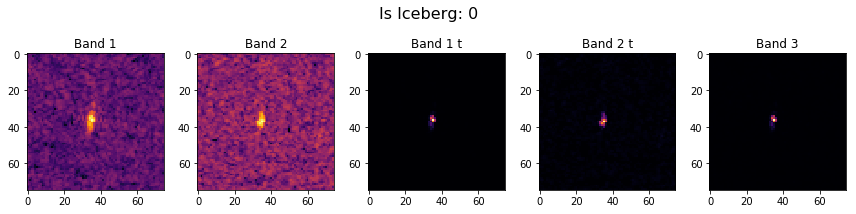

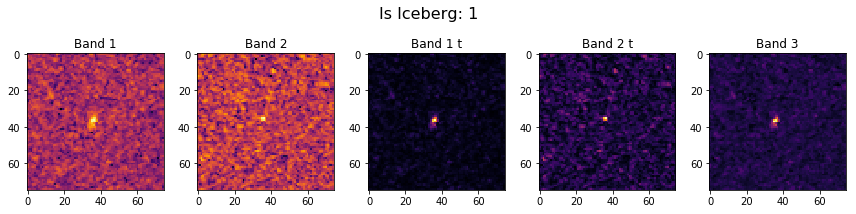

In [17]:
def plot_bands(index, cmap="gray"):
    fig = plt.figure(figsize=(12,6))
    fig.suptitle("Is Iceberg: %x" % (train_df.loc[index,'is_iceberg']), fontsize=16)
    ax1 = fig.add_subplot(251)
    ax1.set_title("Band 1")
    ax1.imshow(band_1[index], cmap=cmap)
    ax2 = fig.add_subplot(252)
    ax2.set_title("Band 2")
    ax2.imshow(band_2[index], cmap=cmap)
    ax3 = fig.add_subplot(253)
    ax3.set_title("Band 1 t")
    ax3.imshow(band_1_t[index], cmap=cmap)
    ax3 = fig.add_subplot(254)
    ax3.set_title("Band 2 t")
    ax3.imshow(band_2_t[index], cmap=cmap)
    ax3 = fig.add_subplot(255)
    ax3.set_title("Band 3")
    ax3.imshow(band_3[index], cmap=cmap)
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

plot_bands(0,cmap="inferno")
plot_bands(2,cmap="inferno")


In [18]:
y = train_df.loc[:,'is_iceberg']
y_angle = train_df.loc[:,['is_iceberg','inc_angle_f']]
y_angle['index'] = y_angle.index

In [19]:
y_angle.head()

,is_iceberg,inc_angle_f,index
0,0,43.9239,0
1,0,38.1562,1
2,1,45.2859,2
3,0,43.8306,3
4,0,35.6256,4


### Split into train test and validation sets

In [20]:
X_train, X_val, y_train, y_val = train_test_split(X, y_angle, test_size=0.35, random_state=random_seed)
print(X_train.shape)
print(X_val.shape)

(1042, 75, 75, 4)
(562, 75, 75, 4)


In [21]:
X_val_tune, X_val_test, y_val_tune, y_val_test = train_test_split(X_val, y_val, test_size=0.3, random_state=random_seed)
print(X_val_tune.shape)
print(X_val_test.shape)

(393, 75, 75, 4)
(169, 75, 75, 4)


### Data augmentation

In [22]:
X_train_sample = X_train[:]
y_train_sample = y_train[:]
print(X_train_sample.shape)

datagen = ImageDataGenerator(
    samplewise_center=False,
    samplewise_std_normalization=False,
    rotation_range=20,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest')

datagen_val = ImageDataGenerator(
    samplewise_center=False,
    samplewise_std_normalization=False,
    rotation_range=0,
    horizontal_flip=False,
    vertical_flip=False,
    fill_mode='nearest')

#custom generator for fit_generator
from collections import Generator
class Datagen_angle(Generator):
    def __init__(self, imagegen=ImageDataGenerator):
        self.imagegen = imagegen
        
    def flow(self, x, y, batch_size=8, shuffle=True):
        self.generator = self.imagegen.flow(x, y, batch_size=batch_size, shuffle=shuffle)
        return self
    
    def send(self, ignored):
        temp_data = next(self.generator)
        temp_band_3 = temp_data[0][:,:,:,2] - temp_data[0][:,:,:,3] #band_1_t - band_2_t
        temp_stacked1 = np.stack((temp_data[0][:,:,:,0],temp_data[0][:,:,:,1]),axis=3)
        temp_stacked2 = np.stack((temp_data[0][:,:,:,2],temp_data[0][:,:,:,3],temp_band_3),axis=3)
        nn_denoised_temp = temp_data[0] #pass 4 bands for nn denoising input
        return [temp_stacked1, temp_stacked2, 
                nn_denoised_temp,
                temp_data[1][:,1]], temp_data[1][:,0]
    
    def throw(self, type=None, value=None, traceback=None):
        raise StopIteration
    

datagen.fit(X_train_sample)
datagen_val.fit(X_val)

datagen_angle = Datagen_angle(imagegen=datagen)
datagen_angle_val = Datagen_angle(imagegen=datagen_val)


(1042, 75, 75, 4)


### Learning rate scheduler and callback definition

In [18]:
# learning rate schedule
class LScheduler:
    def __init__(self, initial_lrate=0.001, drop=0.66, patience=5):
        self.initial_lrate=initial_lrate
        self.drop = drop
        self.patience = patience

    def step_decay(self,epoch):
        initial_lrate = self.initial_lrate
        drop = self.drop
        patience = self.patience
        lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/patience))
        if math.fmod(epoch, patience) == 0:
            print("Setting learning rate: ",lrate)
        return lrate

### Denoising

In [19]:
def denoising(img):
    img_list = []
    for i in range(4):
        image = normalize(img[:,:,i])
        img_list.append(ndimage.median_filter(image, 3))
    return np.stack(img_list,axis=2)

In [20]:
def apply_over_axis(func, data, mask=None, axis=0, *args, **kwargs):
    f_list = []
    for i in range(data.shape[axis]):
        if mask is None:
            f_list.append(func(data[i], *args, **kwargs))
        else:
            f_list.append(func(data[i], mask=mask[i], *args, **kwargs))
    return np.stack(f_list,axis=0)

In [21]:
#X_denoised = apply_over_axis(denoising, X)

In [22]:
#index=8
#original_index = y_train_sample.iloc[index].name
#cmap="inferno"
#fig = plt.figure(figsize=(12,6))
#fig.suptitle("Denoising: is iceberg: %x" % (y_train_sample.iloc[index,0]), fontsize=16)
#ax1 = fig.add_subplot(251)
#ax1.set_title("Before")
#ax1.imshow(X_train_sample[index][:,:,0], cmap=cmap)
#ax2 = fig.add_subplot(252)
#ax2.set_title("Denoised")
#ax2.imshow(X_denoised[original_index][:,:,0], cmap=cmap)
#ax1 = fig.add_subplot(253)
#ax1.set_title("Before - band 2")
#ax1.imshow(X_train_sample[index][:,:,1], cmap=cmap)
#ax2 = fig.add_subplot(254)
#ax2.set_title("Denoised - band 2")
#ax2.imshow(X_denoised[original_index][:,:,1], cmap=cmap)
#plt.show()

### NN denoising

In [23]:
#custom generator for denoising
from collections import Generator
class Datagen_denoising(Generator):
    def __init__(self, imagegen=ImageDataGenerator):
        self.imagegen = imagegen
        
    def flow(self, x, y, batch_size=8, shuffle=True):
        self.generator = self.imagegen.flow(x, y, batch_size=batch_size, shuffle=shuffle)
        return self
    
    def send(self, ignored):
        temp_data = next(self.generator)
        temp_stacked1 = np.stack((temp_data[0][:,:,:,0],temp_data[0][:,:,:,1]),axis=3)
        temp_stacked = np.stack((temp_data[0][:,:,:,0],temp_data[0][:,:,:,1],temp_data[0][:,:,:,2],
                                temp_data[0][:,:,:,3]),axis=3)
        return temp_stacked, temp_stacked
    
    def throw(self, type=None, value=None, traceback=None):
        raise StopIteration
        
datagen_denoising = Datagen_denoising(imagegen=datagen)
datagen_denoising_val = Datagen_denoising(imagegen=datagen_val)

In [24]:
m_input = Input(shape=(75,75,4), name='m_input')

#conv layers for main_input
x1 = BatchNormalization()(m_input)
x1 = ZeroPadding2D()(x1)
x1 = Conv2D(8, (3,3), activation='relu')(x1)
x1 = BatchNormalization()(x1)
x1 = Dropout(0.2)(x1)
x1 = ZeroPadding2D()(x1)
x1 = Conv2D(8, (3,3), activation='relu')(x1)
x1 = BatchNormalization()(x1)
x1 = Dropout(0.2)(x1)
x1 = ZeroPadding2D()(x1)
m_output = Conv2D(4, (3,3), activation='linear', name='m_output')(x1)
model_denoise = Model(inputs=[m_input,], outputs=[m_output], name='Model_nn_denoising')

model_denoise.compile(optimizer=Adam(lr=0.1, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0),
loss='mean_squared_error',
metrics=['mae'])

In [25]:
model_denoise.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
m_input (InputLayer)         (None, 75, 75, 4)         0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 75, 75, 4)         16        
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 77, 77, 4)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 75, 75, 8)         296       
_________________________________________________________________
batch_normalization_2 (Batch (None, 75, 75, 8)         32        
_________________________________________________________________
dropout_1 (Dropout)          (None, 75, 75, 8)         0         
_________________________________________________________________
zero_padding2d_2 (ZeroPaddin (None, 77, 77, 8)         0         
__________

In [26]:
#model training
#lScheduler_denoising = LScheduler(initial_lrate=0.1, drop=0.66, patience=3)
#lrScheduler_denoising = LearningRateScheduler(lScheduler_denoising.step_decay)
lrScheduler_denoising = CyclicLR(base_lr=1e-8, max_lr=0.006,
                                 step_size=400, mode='triangular2', gamma=0.99994)
start_time = time.monotonic()

H = model_denoise.fit_generator(datagen_denoising.flow(X, y_angle, batch_size=8),
                    steps_per_epoch=len(X)/8,
                    validation_data=datagen_denoising_val.flow(X, y_angle, batch_size=8, shuffle=False), 
                    validation_steps=len(X)/8,
                    #validation_data=[X_val,y_val],
                    epochs=12,
                    callbacks = [lrScheduler_denoising, 
                                 TQDMNotebookCallback(leave_inner=True, leave_outer=True)],
                    verbose=0)

model_time = time.monotonic() - start_time
print("Model training time: " + '{:d}'.format(int(model_time // 60)) + " minutes " 
      + '{:.1f}'.format(model_time % 60) + " seconds")

HBox(children=(IntProgress(value=0, description='Training', max=12), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 0', max=200), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 1', max=200), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 2', max=200), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 3', max=200), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 4', max=200), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 5', max=200), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 6', max=200), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 7', max=200), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 8', max=200), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 9', max=200), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 10', max=200), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 11', max=200), HTML(value='')))


Model training time: 1 minutes 7.6 seconds


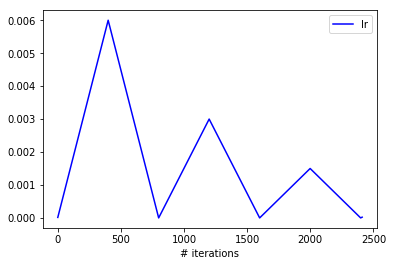

In [27]:
h = lrScheduler_denoising.history
plt.plot(h['lr'], color="b", label='lr')
plt.legend()
plt.xlabel('# iterations')
plt.show()

In [28]:
# serialize model to JSON
model_json = model_denoise.to_json()
with open("models/model_denoise.json", "w") as json_file:
    json_file.write(model_json)

In [29]:
# serialize weights to HDF5
model_weights = model_denoise.get_weights()
with open('models/model_denoise_weights.pickle', 'wb') as handle:
    pickle.dump(model_weights, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [30]:
# load json and create model
with open("models/model_denoise.json", "r") as json_file:
    loaded_model_json = json_file.read()
model_denoise = model_from_json(loaded_model_json)
# load weights into new model
with open('models/model_denoise_weights.pickle', 'rb') as handle:
    model_weights = pickle.load(handle)
model_denoise.set_weights(model_weights)
print("Loaded model from disk")

Loaded model from disk


In [31]:
X_nn_denoised = model_denoise.predict(X, verbose=1)

1604/1604 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 1s 875us/step


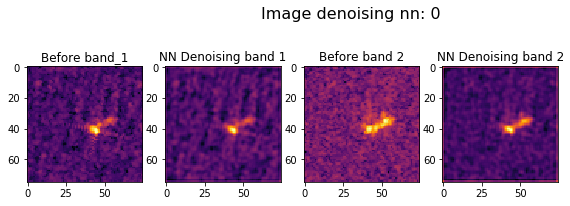

In [32]:
index=8
original_index = y_train_sample.iloc[index].name
cmap="inferno"
fig = plt.figure(figsize=(12,6))
fig.suptitle("Image denoising nn: %x" % (train_df.loc[original_index,'is_iceberg']), fontsize=16)
ax1 = fig.add_subplot(251)
ax1.set_title("Before band_1")
ax1.imshow(X_train_sample[index][:,:,0], cmap=cmap)
ax2 = fig.add_subplot(252)
ax2.set_title("NN Denoising band 1")
ax2.imshow(X_nn_denoised[original_index][:,:,0], cmap=cmap)
ax3 = fig.add_subplot(253)
ax3.set_title("Before band 2")
ax3.imshow(X_train_sample[index][:,:,1], cmap=cmap)
ax4 = fig.add_subplot(254)
ax4.set_title("NN Denoising band 2")
ax4.imshow(X_nn_denoised[original_index][:,:,1], cmap=cmap)
plt.show()

### Keras model

In [33]:
model_code="CNN_2018_01_21_v01"
model_comment="2 CNN inputs 3,3 conv filters - 3rd input nn denoising, na=0"

In [34]:
%%writefile current_model.py

def InputBlock(x, dropout=0.25, prefix=''):
    #conv layers for input
    x = BatchNormalization()(x)
    x = Conv2D(64, (3,3), activation='relu')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2))(x)
    x = BatchNormalization()(x)
    x = Dropout(dropout)(x) 
    x = Conv2D(64, (3,3), activation='relu')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2))(x)
    x = BatchNormalization()(x)
    x = Dropout(dropout)(x) 
    return(x)

main_input = Input(shape=(75,75,2), name='main_input')
aux_input = Input(shape=(75,75,3), name='aux_input')
aux_input_nn = Input(shape=(75,75,4), name='aux_input_nn')

x1 = InputBlock(main_input, prefix='m_input')
x2 = InputBlock(aux_input, prefix='a_input')
x3 = model_denoise(aux_input_nn)
x3 = InputBlock(x3,dropout=0.25, prefix='a_input_nn')

x = Concatenate(axis=3)([x1,x2,x3])
#x = BatchNormalization()(x)
#x = Dropout(0.2)(x)

#conv-block
x = Conv2D(128, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2), strides=(2, 2))(x)
x = BatchNormalization()(x)
x = Dropout(0.25)(x)

#conv-block
x = Conv2D(256, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2), strides=(2, 2))(x)
x = BatchNormalization()(x)
x = Dropout(0.25)(x)
    
#flatten
x = Flatten()(x)
angle_input = Input(shape=[1], name='angle_input')
#x1 = BatchNormalization()(angle_input)
merged = Concatenate()([x, angle_input])

#dense-block
x = Dense(513, activation='relu')(merged)
x = BatchNormalization()(x)
x = Dropout(0.25)(x)

#dense-block
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.25)(x)

main_output = Dense(1, activation='sigmoid', name='main_output')(x)
model_f = Model(inputs=[main_input,aux_input, 
                        aux_input_nn, 
                        angle_input], 
                        outputs=[main_output])

model_f.compile(optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0),
loss='binary_crossentropy',
metrics=['accuracy'])

Overwriting current_model.py


In [35]:
%run -i current_model.py

In [6]:
class ModelHistory(Callback):
    def __init__(self, listSize=10):
        self.listSize = listSize
        self.models = []

    def on_epoch_end(self, epoch, logs={}):
        lastLoss = logs.get('val_loss')
        rank = 1 - lastLoss
        if len(self.models) > 0:
            if rank > self.models[0][0]: # new model is better than the worst in the heap
                if len(self.models) >= self.listSize: #if the model heap is already full
                    heapq.heappushpop(self.models, (rank, lastLoss, self.model.get_weights()))
                else:
                    heapq.heappush(self.models, (rank, lastLoss, self.model.get_weights()))
        else:
            heapq.heappush(self.models, (rank, lastLoss, self.model.get_weights()))

def get_callbacks(filepath, save_to_disc = True, lScheduler = None,
                  patience=10, step_decay=LScheduler().step_decay, modelHistoryCallback=None):
    #es = EarlyStopping('val_loss', patience=patience, mode="min")
    msave = ModelCheckpoint(filepath, save_best_only=True)
    #reduceLr = ReduceLROnPlateau(monitor='val_loss', factor=0.5,
    #                          patience=5, min_lr=0.000001, verbose=1)
    if lScheduler is None:
        lrScheduler = LearningRateScheduler(step_decay)
    else:
        lrScheduler = lScheduler
    tqdmCallback =  TQDMNotebookCallback(leave_inner=True, leave_outer=True)
    if (save_to_disc):
        return [msave, lrScheduler, modelHistoryCallback, tqdmCallback]
    else:
        return [lrScheduler, modelHistoryCallback, tqdmCallback]

NameError: name 'LScheduler' is not defined

In [37]:
model_f.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
aux_input_nn (InputLayer)       (None, 75, 75, 4)    0                                            
__________________________________________________________________________________________________
main_input (InputLayer)         (None, 75, 75, 2)    0                                            
__________________________________________________________________________________________________
aux_input (InputLayer)          (None, 75, 75, 3)    0                                            
__________________________________________________________________________________________________
Model_nn_denoising (Model)      (None, 75, 75, 4)    1252        aux_input_nn[0][0]               
__________________________________________________________________________________________________
batch_norm

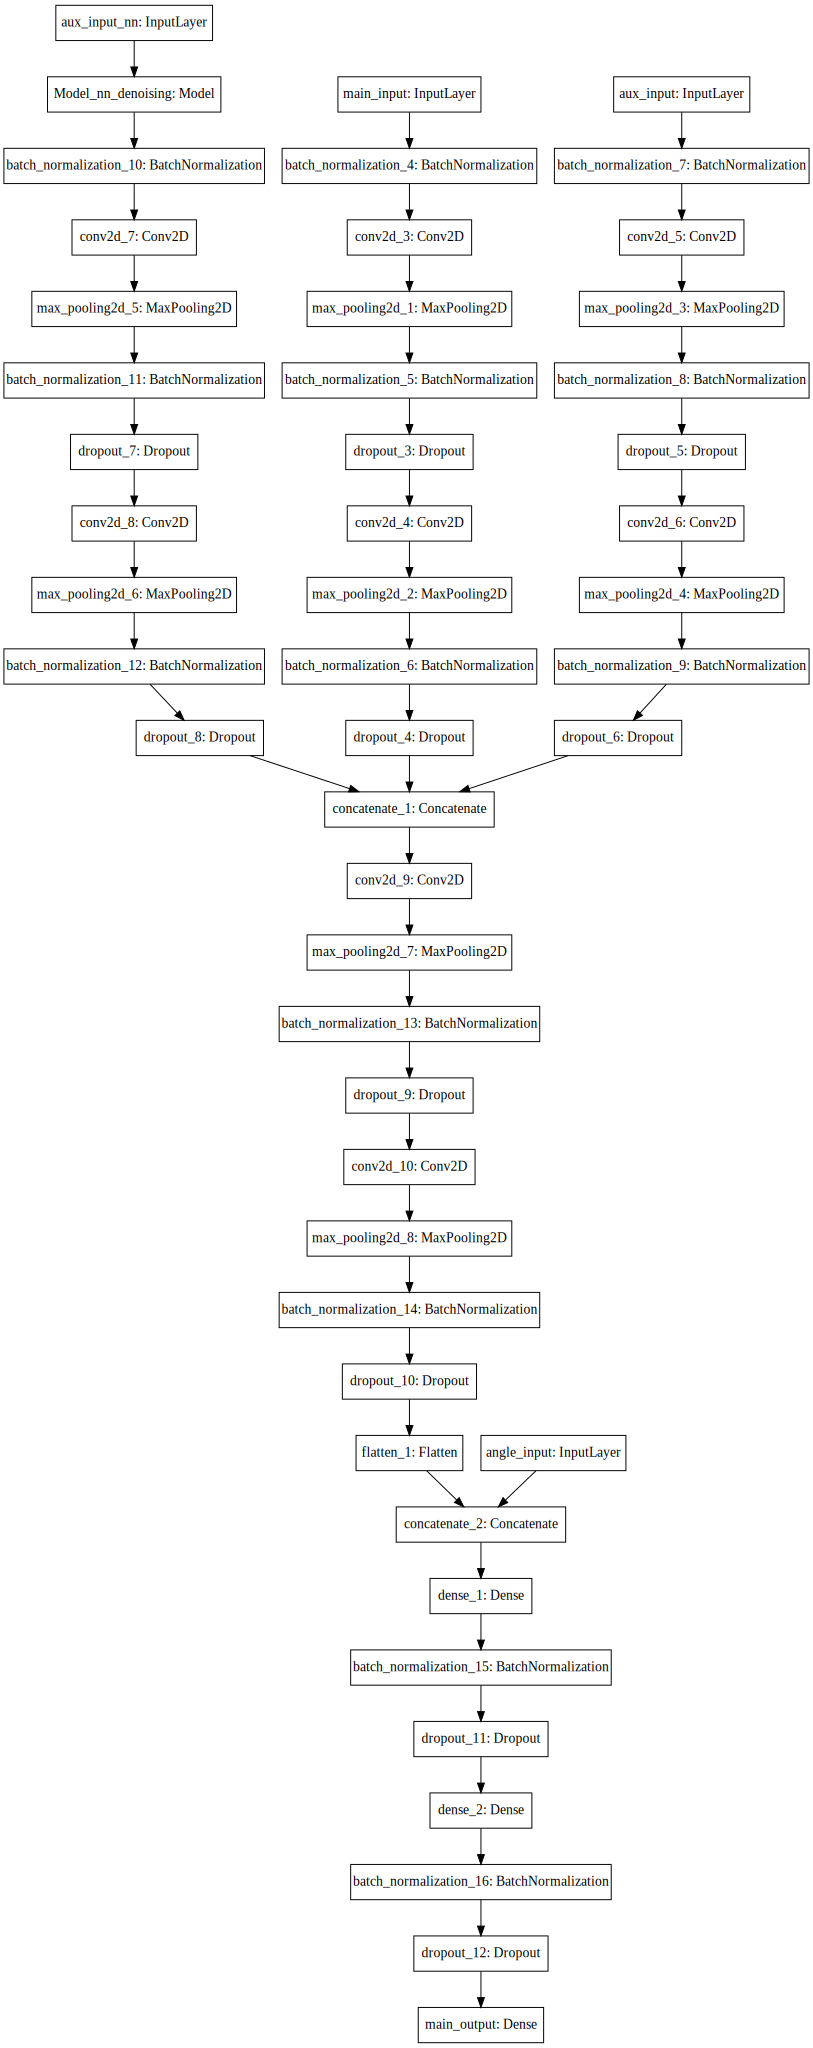

In [38]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
#import os
#os.environ["PATH"] += os.pathsep + 'd:/Anaconda3/Library/bin/graphviz/'
SVG(model_to_dot(model_f).create(prog='dot', format='svg'))

### Model Training

In [39]:
#name init
model_timestamp = str(datetime.datetime.now().strftime("%Y_%m_%d_%H_%M_%S"))
model_best_weights_path = model_path + "weights." + model_code + "_" + model_timestamp + ".hdf5"
#lScheduler = LScheduler(initial_lrate=0.001, drop=0.66, patience=7)
modelEnsemble = ModelHistory(listSize=21)
lScheduler = CyclicLR(base_lr=0.0003, max_lr=0.002,
                                 step_size=250, mode='triangular3', beta=0.33, theta=0.11)
callbacks = get_callbacks(filepath=model_best_weights_path, save_to_disc=False, lScheduler=lScheduler,
                          modelHistoryCallback=modelEnsemble)

In [40]:
#model training
start_time = time.monotonic()

H = model_f.fit_generator(datagen_angle.flow(X_train_sample, y_train_sample, batch_size=16),
                    steps_per_epoch=len(X_train_sample)/16,
                    validation_data=datagen_angle_val.flow(X_val_tune, y_val_tune, batch_size=24, shuffle=False), 
                    validation_steps=len(X_val)/24,
                    #validation_data=[X_val,y_val],
                    epochs=150, callbacks=callbacks,
                    verbose=0)

model_time = time.monotonic() - start_time
print("Model training time: " + '{:d}'.format(int(model_time // 60)) + " minutes " 
      + '{:.1f}'.format(model_time % 60) + " seconds")

HBox(children=(IntProgress(value=0, description='Training', max=150), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 0', max=65), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 1', max=65), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 2', max=65), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 3', max=65), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 4', max=65), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 5', max=65), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 6', max=65), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 7', max=65), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 8', max=65), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 9', max=65), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 10', max=65), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 11', max=65), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 12', max=65), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 13', max=65), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 14', max=65), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 15', max=65), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 16', max=65), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 17', max=65), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 18', max=65), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 19', max=65), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 20', max=65), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 21', max=65), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 22', max=65), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 23', max=65), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 24', max=65), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 25', max=65), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 26', max=65), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 27', max=65), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 28', max=65), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 29', max=65), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 30', max=65), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 31', max=65), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 32', max=65), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 33', max=65), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 34', max=65), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 35', max=65), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 36', max=65), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 37', max=65), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 38', max=65), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 39', max=65), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 40', max=65), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 41', max=65), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 42', max=65), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 43', max=65), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 44', max=65), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 45', max=65), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 46', max=65), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 47', max=65), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 48', max=65), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 49', max=65), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 50', max=65), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 51', max=65), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 52', max=65), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 53', max=65), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 54', max=65), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 55', max=65), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 56', max=65), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 57', max=65), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 58', max=65), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 59', max=65), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 60', max=65), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 61', max=65), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 62', max=65), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 63', max=65), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 64', max=65), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 65', max=65), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 66', max=65), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 67', max=65), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 68', max=65), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 69', max=65), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 70', max=65), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 71', max=65), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 72', max=65), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 73', max=65), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 74', max=65), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 75', max=65), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 76', max=65), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 77', max=65), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 78', max=65), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 79', max=65), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 80', max=65), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 81', max=65), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 82', max=65), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 83', max=65), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 84', max=65), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 85', max=65), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 86', max=65), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 87', max=65), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 88', max=65), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 89', max=65), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 90', max=65), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 91', max=65), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 92', max=65), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 93', max=65), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 94', max=65), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 95', max=65), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 96', max=65), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 97', max=65), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 98', max=65), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 99', max=65), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 100', max=65), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 101', max=65), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 102', max=65), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 103', max=65), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 104', max=65), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 105', max=65), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 106', max=65), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 107', max=65), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 108', max=65), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 109', max=65), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 110', max=65), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 111', max=65), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 112', max=65), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 113', max=65), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 114', max=65), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 115', max=65), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 116', max=65), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 117', max=65), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 118', max=65), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 119', max=65), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 120', max=65), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 121', max=65), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 122', max=65), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 123', max=65), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 124', max=65), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 125', max=65), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 126', max=65), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 127', max=65), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 128', max=65), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 129', max=65), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 130', max=65), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 131', max=65), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 132', max=65), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 133', max=65), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 134', max=65), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 135', max=65), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 136', max=65), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 137', max=65), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 138', max=65), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 139', max=65), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 140', max=65), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 141', max=65), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 142', max=65), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 143', max=65), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 144', max=65), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 145', max=65), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 146', max=65), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 147', max=65), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 148', max=65), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 149', max=65), HTML(value='')))


Model training time: 38 minutes 40.6 seconds


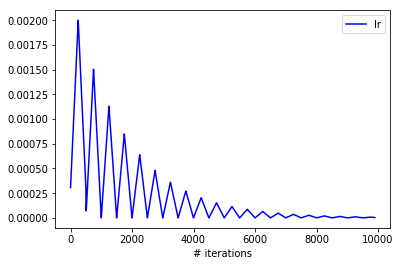

In [41]:
h = lScheduler.history
plt.plot(h['lr'], color="b", label='lr')
plt.legend()
plt.xlabel('# iterations')
plt.show()

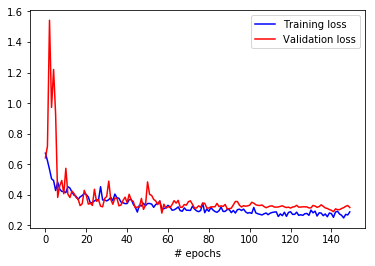

In [42]:
plt.plot(H.history['loss'], color="b", label='Training loss')
plt.plot(H.history['val_loss'], color="r", label='Validation loss')
plt.legend()
plt.xlabel('# epochs')
plt.show()

In [43]:
model_f.set_weights(heapq.nlargest(1,modelEnsemble.models)[0][2])

### Additional training epochs with SGD - warm start

In [44]:
#addtional training epochs - warm start
#lScheduler = LScheduler(initial_lrate=0.000001, drop=0.66, patience=3)
modelEnsemble2 = ModelHistory(listSize=5)
lScheduler = CyclicLR(base_lr=1e-8, max_lr=1e-6,
                                 step_size=80, mode='triangular3', beta=0.33, theta=0.11)
callbacks = get_callbacks(filepath=model_best_weights_path, save_to_disc=False, lScheduler=lScheduler,
                          modelHistoryCallback=modelEnsemble2)
model_f.compile(optimizer=SGD(lr=0.0001),loss='binary_crossentropy',metrics=['accuracy'])
start_time = time.monotonic()

H2 = model_f.fit_generator(datagen_angle.flow(X_train_sample, y_train_sample, batch_size=24, shuffle=False),
                    steps_per_epoch=len(X_train_sample)/24,
                    validation_data=datagen_angle_val.flow(X_val_tune, y_val_tune, batch_size=24, shuffle=False), 
                    validation_steps=len(X_val)/24,
                    #validation_data=[X_val,y_val],
                    epochs=15, callbacks=callbacks,
                    verbose=0)

model_time = time.monotonic() - start_time
print("Model training time: " + '{:d}'.format(int(model_time // 60)) + " minutes " 
      + '{:.1f}'.format(model_time % 60) + " seconds")

HBox(children=(IntProgress(value=0, description='Training', max=15), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 0', max=43), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 1', max=43), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 2', max=43), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 3', max=43), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 4', max=43), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 5', max=43), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 6', max=43), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 7', max=43), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 8', max=43), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 9', max=43), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 10', max=43), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 11', max=43), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 12', max=43), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 13', max=43), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 14', max=43), HTML(value='')))


Model training time: 3 minutes 50.9 seconds


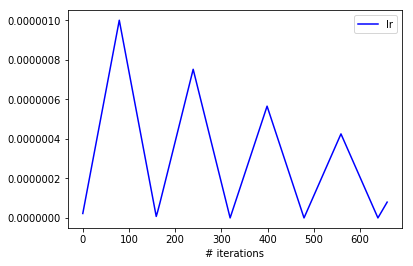

In [45]:
h = lScheduler.history
plt.plot(h['lr'], color="b", label='lr')
plt.legend()
plt.xlabel('# iterations')
plt.show()

In [46]:
for key in H.history:
    H.history[key].extend(H2.history[key])

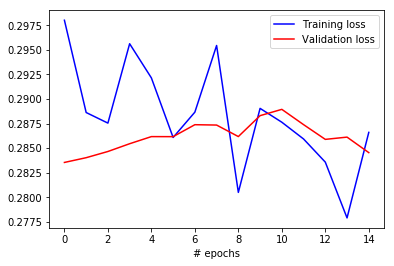

In [47]:
plt.plot(H2.history['loss'], color="b", label='Training loss')
plt.plot(H2.history['val_loss'], color="r", label='Validation loss')
plt.legend()
plt.xlabel('# epochs')
plt.show()

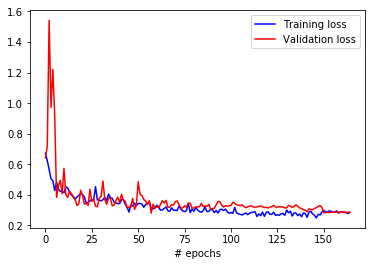

In [48]:
plt.plot(H.history['loss'], color="b", label='Training loss')
plt.plot(H.history['val_loss'], color="r", label='Validation loss')
plt.legend()
plt.xlabel('# epochs')
plt.show()

In [49]:
# serialize model to JSON
model_json = model_f.to_json()
with open("models/model.json", "w") as json_file:
    json_file.write(model_json)

In [4]:
# load model from JSON - don't care about the weights rith now, they are saved separately
with open("models/model.json", "r") as json_file:
    loaded_model_json = json_file.read()
    model_f = model_from_json(loaded_model_json)

In [51]:
#model_object_path = model_path + "model." + model_code + "_" + model_timestamp + '.hdf5'
#model_f.save('models/last_model.hdf5') //crashes python kernel with Keras version 2.1.2
#model_f = load_model(model_object_path)

### Saving model history

In [52]:
argmin = np.array(H.history["loss"]).argmin()
argmin

146

In [53]:
argmin = np.array(H.history["val_loss"]).argmin()
argmax_acc = np.array(H.history["val_acc"]).argmax()
#with open('current_model.py','r') as model_python_code_file:
#    models_history = pd.DataFrame({"timestamp":[model_timestamp], 
#                                    "val_loss [min]":[H.history['val_loss'][argmin]],
#                                    "epoch [val_loss [min]]":argmin,
#                                    "training_loss [val_loss [min]]":[H.history['loss'][argmin]],
#                                    "val_acc [val_loss [min]]":[H.history['val_acc'][argmin]],
#                                    "training_acc [val_loss [min]]":[H.history['acc'][argmin]],
#                                    
#                                    "val_acc [max]":[H.history['val_acc'][argmax_acc]],
#                                    "epoch [val_acc [max]]":argmax_acc,
#                                    "training_loss [val_acc [max]]":[H.history['loss'][argmax_acc]],
#                                    "val_loss [val_acc [max]]":[H.history['val_loss'][argmax_acc]],
#                                    "training_acc [val_acc [max]]":[H.history['acc'][argmax_acc]],
#                                    
#                                    "model_path":[model_object_path],
#                                    "model_weights_path":[model_best_weights_path],
#                                    "model_python_code":[model_python_code_file.read().replace('\r\n','\n')],
#                                    "model_comment":[model_comment]
#                                })
#                               
#models_history = models_history[["timestamp", 
#                                 "epoch [val_loss [min]]", "val_loss [min]", "training_loss [val_loss [min]]",
#                                 "val_acc [val_loss [min]]", "training_acc [val_loss [min]]",
#                                 "epoch [val_acc [max]]", "val_acc [max]", "training_loss [val_acc [max]]",
#                                 "val_loss [val_acc [max]]", "training_acc [val_acc [max]]",
#                                 "model_path","model_weights_path","model_python_code","model_comment"]]
#models_history.head()

In [54]:
#print("Min validation loss epoch:")
#print("epoch: %d" %(argmin),
#      "; val loss [min] %.4f: " % (models_history["val_loss [min]"][0]), 
#      "; training loss: %.4f" % (models_history["training_loss [val_loss [min]]"][0]),
#      "; val acc: %.4f" % (models_history["val_acc [val_loss [min]]"][0]),
#      "; training acc: %.4f " % (models_history["training_acc [val_loss [min]]"][0])
#     )
#print("Max validation accuracy epoch:")
#print("epoch: %d" %(argmax_acc),
#      "; val loss %.4f: " % (models_history["val_loss [val_acc [max]]"][0]), 
#      "; training loss: %.4f" % (models_history["training_loss [val_acc [max]]"][0]),
#      "; val acc [max]: %.4f" % (models_history["val_acc [max]"][0]),
#      "; training acc: %.4f " % (models_history["training_acc [val_acc [max]]"][0]),
#     )
#print("model comment:", model_comment)
#

In [55]:
#with open('models_history.csv', 'a') as f:
#    models_history.to_csv(f, header=False,index=False)
#    #models_history.to_csv(f, index=False)

In [56]:
#df = pd.read_csv('models_history.csv')
#df.tail()

### Model Ensemble

In [57]:
heapq.heappush(modelEnsemble.models, heapq.nlargest(1,modelEnsemble2.models)[0])

In [7]:
modelEnsemble = ModelHistory(listSize=26)
with open('models/modelEnsemble.pickle', 'rb') as handle:
    modelEnsemble.models = pickle.load(handle)

In [ ]:
#model_f.set_weights(heapq.nlargest(1,modelEnsemble.models)[0][2])
model_f.set_weights(heapq.nsmallest(1,modelEnsemble.models)[0][2])
model_f.compile(optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0),
loss='binary_crossentropy',
metrics=['accuracy'])
model_f.evaluate_generator(datagen_angle_val.flow(X_val_test, y_val_test, batch_size=16, shuffle=True), 
                           steps = len(X)/6)

In [60]:
with open('models/modelEnsemble.pickle', 'wb') as handle:
    pickle.dump(modelEnsemble.models, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [61]:
with open('models/modelEnsemble.pickle', 'rb') as handle:
    modelEnsemble.models = pickle.load(handle)

In [62]:
def get_prediction(model,weights, X, y):
    model.set_weights(weights)
    return model.predict_generator(datagen_angle_val.flow(X, y, batch_size=32, shuffle=False), 
                           steps = len(X)/31, verbose=1)

In [63]:
def get_ensemble_predictions(X, y, modelEnsemble):
    predictions = [get_prediction(model_f, model[2], X, y)[:X.shape[0]]
                   for model in tqdm(modelEnsemble.models)]    
    temp_array = np.array(predictions)
    del(predictions)
    temp_array = np.swapaxes(temp_array,0,1)
    temp_array = temp_array.reshape(temp_array.shape[0],temp_array.shape[1])
    return temp_array

In [64]:
#with h5py.File('tmp_data/ensemble_data.h5', 'r') as hf:
#    ensemble_train = hf['ensemble_train'][:]

In [65]:
modelEnsemble.models[0][0]

0.83766611993312834

In [66]:
ensemble_val = get_ensemble_predictions(X_val, y_val, modelEnsemble)
with h5py.File('tmp_data/ensemble_data.h5', 'w') as hf:
    hf.create_dataset("ensemble_val",  data=ensemble_val)
ensemble_val.shape

HBox(children=(IntProgress(value=0, max=22), HTML(value='')))

19/18 [===============================]- ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 2s 106ms/step



(562, 22)

In [75]:
ensemble_val_tune = get_ensemble_predictions(X_val_tune, y_val_tune, modelEnsemble)
with h5py.File('tmp_data/ensemble_data.h5', 'a') as hf:
    hf.create_dataset("ensemble_val_tune",  data=ensemble_val_tune)
ensemble_val.shape

HBox(children=(IntProgress(value=0, max=22), HTML(value='')))

13/12 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 1s 102ms/step



(562, 22)

In [76]:
ensemble_val_test = get_ensemble_predictions(X_val_test, y_val_test, modelEnsemble)
with h5py.File('tmp_data/ensemble_data.h5', 'a') as hf:
    hf.create_dataset("ensemble_val_test",  data=ensemble_val_test)
ensemble_val.shape

HBox(children=(IntProgress(value=0, max=22), HTML(value='')))

6/5 [=================================]ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 1s 96ms/step



(562, 22)

In [67]:
#with h5py.File('tmp_data/ensemble_data.h5', 'r') as hf:
#    ensemble_val = hf['ensemble_val'][:]

In [68]:
ensemble_val[1]

array([ 0.47820842,  0.4435049 ,  0.49707878,  0.28786373,  0.37447438,
        0.51703519,  0.27355012,  0.38437542,  0.49973378,  0.40308195,
        0.35731828,  0.26179376,  0.40282699,  0.44629514,  0.44436553,
        0.42271957,  0.21234639,  0.26366764,  0.28083801,  0.29540062,
        0.50118792,  0.30187637], dtype=float32)

In [69]:
def modelfit(alg, X, y , X_test, y_test, useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(X, label=y)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='logloss', early_stopping_rounds=early_stopping_rounds)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(X, y,eval_metric='logloss')
        
    #Predict training set:
    dtrain_predictions = alg.predict(X)
    dtrain_predprob = alg.predict_proba(X)[:,1]
    dtest_predprob = alg.predict_proba(X_test)[:,1]
        
    #Print model report:
    print("\nModel Report")
    print("n_estimators: %d" % cvresult.shape[0])
    print("Accuracy : %.4g" % metrics.accuracy_score(y, dtrain_predictions))
    print("Log loss (Train): %f" % metrics.log_loss(y, dtrain_predprob))
    print("Log loss (Test): %f" % metrics.log_loss(y_test, dtest_predprob))
                    
    feat_imp = pd.Series(alg.booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')
    plt.show()

In [70]:
#ensemble_train = get_ensemble_predictions(X_train, y_train, modelEnsemble)
#with h5py.File('tmp_data/ensemble_data.h5', 'a') as hf:
#    hf.create_dataset("ensemble_train",  data=ensemble_train)

In [71]:
#with h5py.File('tmp_data/ensemble_data.h5', 'r') as hf:
#    ensemble_train = hf['ensemble_train'][:]

In [72]:
#ensemble_train[0]

In [73]:
#ensemble_all = get_ensemble_predictions(X, y_angle, modelEnsemble)

### Fine tuning ensemble with xgboost


Model Report
n_estimators: 82
Accuracy : 0.9898
Log loss (Train): 0.045570
Log loss (Test): 0.231587


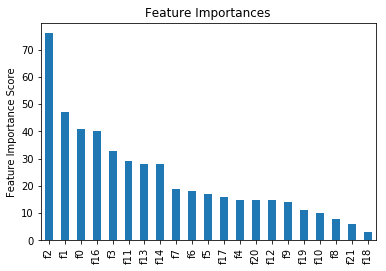

In [77]:
xgb1 = xgb.XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=8,
 scale_pos_weight=1,
 seed=27)
modelfit(xgb1, ensemble_val_tune, y_val_tune['is_iceberg'], ensemble_val_test, y_val_test['is_iceberg'])

In [ ]:
#ensemble_all = get_ensemble_predictions(X, y_angle, modelEnsemble)

In [78]:
param_test1 = {
 'max_depth':list(range(3,13,2)),
 'min_child_weight':list(range(1,10,2))
}
gsearch1 = GridSearchCV(estimator = xgb.XGBClassifier( learning_rate =0.1, n_estimators=82, max_depth=5,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=8, scale_pos_weight=1, seed=random_seed), 
 param_grid = param_test1, scoring='neg_log_loss',n_jobs=1,iid=False, cv=5, verbose=1)
gsearch1.fit(ensemble_val_tune,y_val_tune['is_iceberg'].values)
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:    5.8s finished
D:\Anaconda3\envs\tf-gpu\lib\site-packages\sklearn\model_selection\_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: -0.17984, std: 0.03356, params: {'max_depth': 3, 'min_child_weight': 1},
  mean: -0.17225, std: 0.02412, params: {'max_depth': 3, 'min_child_weight': 3},
  mean: -0.17605, std: 0.02113, params: {'max_depth': 3, 'min_child_weight': 5},
  mean: -0.17899, std: 0.01983, params: {'max_depth': 3, 'min_child_weight': 7},
  mean: -0.18697, std: 0.01644, params: {'max_depth': 3, 'min_child_weight': 9},
  mean: -0.18387, std: 0.03428, params: {'max_depth': 5, 'min_child_weight': 1},
  mean: -0.17331, std: 0.02461, params: {'max_depth': 5, 'min_child_weight': 3},
  mean: -0.17605, std: 0.02113, params: {'max_depth': 5, 'min_child_weight': 5},
  mean: -0.17899, std: 0.01983, params: {'max_depth': 5, 'min_child_weight': 7},
  mean: -0.18697, std: 0.01644, params: {'max_depth': 5, 'min_child_weight': 9},
  mean: -0.18264, std: 0.03409, params: {'max_depth': 7, 'min_child_weight': 1},
  mean: -0.17331, std: 0.02461, params: {'max_depth': 7, 'min_child_weight': 3},
  mean: -0.17605, std: 0.021

In [80]:
param_test2 = {
 'max_depth':[2,3,4],
 'min_child_weight':[2.5,3,3.5,6.5,7,7.5]
}
gsearch2 = GridSearchCV(estimator = xgb.XGBClassifier( learning_rate =0.1, n_estimators=82, max_depth=3,
 min_child_weight=3, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=8, scale_pos_weight=1, seed=random_seed), 
 param_grid = param_test2, scoring='neg_log_loss',n_jobs=1,iid=False, cv=5, verbose=1)
gsearch2.fit(ensemble_val_tune,y_val_tune['is_iceberg'].values)
gsearch2.grid_scores_, gsearch2.best_params_, gsearch2.best_score_

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:    3.7s finished
D:\Anaconda3\envs\tf-gpu\lib\site-packages\sklearn\model_selection\_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: -0.17505, std: 0.02714, params: {'max_depth': 2, 'min_child_weight': 2.5},
  mean: -0.17429, std: 0.02242, params: {'max_depth': 2, 'min_child_weight': 3},
  mean: -0.17341, std: 0.02146, params: {'max_depth': 2, 'min_child_weight': 3.5},
  mean: -0.17697, std: 0.02049, params: {'max_depth': 2, 'min_child_weight': 6.5},
  mean: -0.17899, std: 0.01983, params: {'max_depth': 2, 'min_child_weight': 7},
  mean: -0.18293, std: 0.01834, params: {'max_depth': 2, 'min_child_weight': 7.5},
  mean: -0.17055, std: 0.02951, params: {'max_depth': 3, 'min_child_weight': 2.5},
  mean: -0.17225, std: 0.02412, params: {'max_depth': 3, 'min_child_weight': 3},
  mean: -0.17286, std: 0.02117, params: {'max_depth': 3, 'min_child_weight': 3.5},
  mean: -0.17697, std: 0.02049, params: {'max_depth': 3, 'min_child_weight': 6.5},
  mean: -0.17899, std: 0.01983, params: {'max_depth': 3, 'min_child_weight': 7},
  mean: -0.18293, std: 0.01834, params: {'max_depth': 3, 'min_child_weight': 7.5},
  mean: -0.1

In [83]:
param_test3 = {
 'gamma':[i/20.0 for i in range(0,30)]
}
gsearch3 = GridSearchCV(estimator = xgb.XGBClassifier( learning_rate =0.1, n_estimators=82, max_depth=3,
 min_child_weight=2.5, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=8, scale_pos_weight=1, seed=random_seed), 
 param_grid = param_test3, scoring='neg_log_loss',n_jobs=1,iid=False, cv=5, verbose=1)
gsearch3.fit(ensemble_val_tune,y_val_tune['is_iceberg'].values)
gsearch3.grid_scores_, gsearch3.best_params_, gsearch3.best_score_

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    7.4s finished
D:\Anaconda3\envs\tf-gpu\lib\site-packages\sklearn\model_selection\_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: -0.17055, std: 0.02951, params: {'gamma': 0.0},
  mean: -0.17277, std: 0.02953, params: {'gamma': 0.05},
  mean: -0.17171, std: 0.02956, params: {'gamma': 0.1},
  mean: -0.17078, std: 0.02973, params: {'gamma': 0.15},
  mean: -0.17223, std: 0.02992, params: {'gamma': 0.2},
  mean: -0.17121, std: 0.03051, params: {'gamma': 0.25},
  mean: -0.17144, std: 0.02949, params: {'gamma': 0.3},
  mean: -0.17142, std: 0.02947, params: {'gamma': 0.35},
  mean: -0.17311, std: 0.02922, params: {'gamma': 0.4},
  mean: -0.17200, std: 0.02961, params: {'gamma': 0.45},
  mean: -0.17205, std: 0.02967, params: {'gamma': 0.5},
  mean: -0.17247, std: 0.02995, params: {'gamma': 0.55},
  mean: -0.17192, std: 0.02900, params: {'gamma': 0.6},
  mean: -0.17226, std: 0.02957, params: {'gamma': 0.65},
  mean: -0.17121, std: 0.02987, params: {'gamma': 0.7},
  mean: -0.17194, std: 0.02899, params: {'gamma': 0.75},
  mean: -0.17295, std: 0.02904, params: {'gamma': 0.8},
  mean: -0.17316, std: 0.02946, params: 


Model Report
n_estimators: 76
Accuracy : 0.9822
Log loss (Train): 0.087280
Log loss (Test): 0.200128


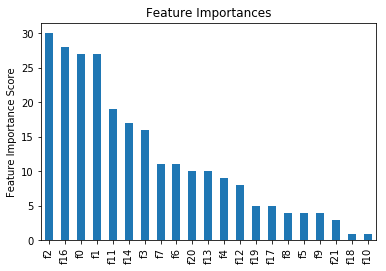

In [84]:
xgb2 = xgb.XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=3,
 min_child_weight=2.5,
 gamma=0.0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=8,
 scale_pos_weight=1,
 seed=27)
modelfit(xgb2, ensemble_val_tune, y_val_tune['is_iceberg'],ensemble_val_test, y_val_test['is_iceberg'])

In [85]:
param_test4 = {
 'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)]
}
gsearch4 = GridSearchCV(estimator = xgb.XGBClassifier( learning_rate =0.1, n_estimators=76, max_depth=3,
 min_child_weight=2.5, gamma=0.0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=8, scale_pos_weight=1, seed=random_seed), 
 param_grid = param_test4, scoring='neg_log_loss',n_jobs=1,iid=False, cv=5, verbose=1)
gsearch4.fit(ensemble_val_tune,y_val_tune['is_iceberg'].values)
gsearch4.grid_scores_, gsearch4.best_params_, gsearch4.best_score_

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed:    3.6s finished
D:\Anaconda3\envs\tf-gpu\lib\site-packages\sklearn\model_selection\_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: -0.16577, std: 0.02449, params: {'colsample_bytree': 0.6, 'subsample': 0.6},
  mean: -0.17135, std: 0.02669, params: {'colsample_bytree': 0.6, 'subsample': 0.7},
  mean: -0.17025, std: 0.02603, params: {'colsample_bytree': 0.6, 'subsample': 0.8},
  mean: -0.17099, std: 0.02885, params: {'colsample_bytree': 0.6, 'subsample': 0.9},
  mean: -0.16814, std: 0.02423, params: {'colsample_bytree': 0.7, 'subsample': 0.6},
  mean: -0.17220, std: 0.02610, params: {'colsample_bytree': 0.7, 'subsample': 0.7},
  mean: -0.17143, std: 0.02861, params: {'colsample_bytree': 0.7, 'subsample': 0.8},
  mean: -0.17227, std: 0.02864, params: {'colsample_bytree': 0.7, 'subsample': 0.9},
  mean: -0.16814, std: 0.02310, params: {'colsample_bytree': 0.8, 'subsample': 0.6},
  mean: -0.17264, std: 0.02655, params: {'colsample_bytree': 0.8, 'subsample': 0.7},
  mean: -0.17022, std: 0.02889, params: {'colsample_bytree': 0.8, 'subsample': 0.8},
  mean: -0.17309, std: 0.02935, params: {'colsample_bytree': 0.8,

In [88]:
param_test5 = {
 'subsample':[i/100.0 for i in range(50,80,5)],
 'colsample_bytree':[i/100.0 for i in range(40,80,5)]
}
gsearch5 = GridSearchCV(estimator = xgb.XGBClassifier( learning_rate =0.1, n_estimators=76, max_depth=3,
 min_child_weight=2.5, gamma=0.0, subsample=0.6, colsample_bytree=0.6,
 objective= 'binary:logistic', nthread=8, scale_pos_weight=1, seed=random_seed), 
 param_grid = param_test5, scoring='neg_log_loss',n_jobs=1,iid=False, cv=5, verbose=1)
gsearch5.fit(ensemble_val_tune,y_val_tune['is_iceberg'].values)
gsearch5.grid_scores_, gsearch5.best_params_, gsearch5.best_score_

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=1)]: Done 240 out of 240 | elapsed:   10.4s finished
D:\Anaconda3\envs\tf-gpu\lib\site-packages\sklearn\model_selection\_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: -0.17317, std: 0.02058, params: {'colsample_bytree': 0.4, 'subsample': 0.5},
  mean: -0.16960, std: 0.02650, params: {'colsample_bytree': 0.4, 'subsample': 0.55},
  mean: -0.16969, std: 0.02633, params: {'colsample_bytree': 0.4, 'subsample': 0.6},
  mean: -0.16691, std: 0.02367, params: {'colsample_bytree': 0.4, 'subsample': 0.65},
  mean: -0.17061, std: 0.02603, params: {'colsample_bytree': 0.4, 'subsample': 0.7},
  mean: -0.16892, std: 0.02486, params: {'colsample_bytree': 0.4, 'subsample': 0.75},
  mean: -0.17573, std: 0.02235, params: {'colsample_bytree': 0.45, 'subsample': 0.5},
  mean: -0.16817, std: 0.02639, params: {'colsample_bytree': 0.45, 'subsample': 0.55},
  mean: -0.16748, std: 0.02478, params: {'colsample_bytree': 0.45, 'subsample': 0.6},
  mean: -0.16674, std: 0.02344, params: {'colsample_bytree': 0.45, 'subsample': 0.65},
  mean: -0.17034, std: 0.02564, params: {'colsample_bytree': 0.45, 'subsample': 0.7},
  mean: -0.17109, std: 0.02538, params: {'colsample_byt

In [89]:
param_test6 = {
 'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
}
gsearch6 = GridSearchCV(estimator = xgb.XGBClassifier( learning_rate =0.1, n_estimators=76, max_depth=3,
 min_child_weight=2.5, gamma=0.0, subsample=0.65, colsample_bytree=0.55,
 objective= 'binary:logistic', nthread=8, scale_pos_weight=1, seed=random_seed), 
 param_grid = param_test6, scoring='neg_log_loss',n_jobs=1,iid=False, cv=5, verbose=1)
gsearch6.fit(ensemble_val_tune,y_val_tune['is_iceberg'].values)
gsearch6.grid_scores_, gsearch6.best_params_, gsearch6.best_score_

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    0.9s finished
D:\Anaconda3\envs\tf-gpu\lib\site-packages\sklearn\model_selection\_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: -0.17260, std: 0.01921, params: {'reg_alpha': 1e-05},
  mean: -0.17197, std: 0.01842, params: {'reg_alpha': 0.01},
  mean: -0.17076, std: 0.01951, params: {'reg_alpha': 0.1},
  mean: -0.17533, std: 0.01805, params: {'reg_alpha': 1},
  mean: -0.69315, std: 0.00000, params: {'reg_alpha': 100}],
 {'reg_alpha': 0.1},
 -0.17076033041325506)

In [92]:
param_test7 = {
 'reg_alpha':[0.0001, 0.0003, 0.001, 0.01, 0.03, 0.1]
}
gsearch7 = GridSearchCV(estimator = xgb.XGBClassifier( learning_rate =0.1, n_estimators=76, max_depth=3,
 min_child_weight=2.5, gamma=0.0, subsample=0.65, colsample_bytree=0.55,
 objective= 'binary:logistic', nthread=8, scale_pos_weight=1, seed=random_seed), 
 param_grid = param_test7, scoring='neg_log_loss',n_jobs=1,iid=False, cv=5, verbose=1)
gsearch7.fit(ensemble_val_tune,y_val_tune['is_iceberg'].values)
gsearch7.grid_scores_, gsearch7.best_params_, gsearch7.best_score_

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    1.3s finished
D:\Anaconda3\envs\tf-gpu\lib\site-packages\sklearn\model_selection\_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: -0.16561, std: 0.02475, params: {'reg_alpha': 0.0001},
  mean: -0.16561, std: 0.02475, params: {'reg_alpha': 0.0003},
  mean: -0.16563, std: 0.02474, params: {'reg_alpha': 0.001},
  mean: -0.16574, std: 0.02464, params: {'reg_alpha': 0.01},
  mean: -0.16760, std: 0.02355, params: {'reg_alpha': 0.03},
  mean: -0.16762, std: 0.02416, params: {'reg_alpha': 0.1}],
 {'reg_alpha': 0.0001},
 -0.16560964614942614)


Model Report
n_estimators: 106
Accuracy : 0.9796
Log loss (Train): 0.093328
Log loss (Test): 0.211374


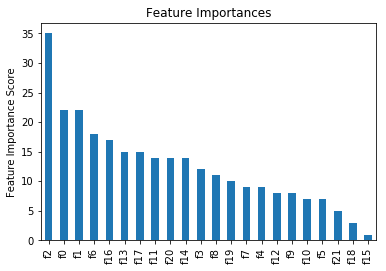

In [93]:
xgb3 = xgb.XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=3,
 min_child_weight=2.5,
 gamma=0.0,
 subsample=0.65,
 colsample_bytree=0.55,
 reg_alpha=0.0001,
 objective= 'binary:logistic',
 nthread=8,
 scale_pos_weight=1,
 seed=27)
modelfit(xgb3, ensemble_val_tune, y_val_tune['is_iceberg'], ensemble_val_test, y_val_test['is_iceberg'])


Model Report
n_estimators: 559
Accuracy : 0.9542
Log loss (Train): 0.121764
Log loss (Test): 0.190643


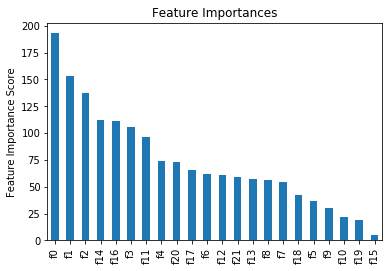

In [113]:
xgb4 = xgb.XGBClassifier(
 learning_rate =0.008,
 n_estimators=1000,
 max_depth=3,
 min_child_weight=3,
 gamma=0.0,
 subsample=0.65,
 colsample_bytree=0.55,
 reg_alpha=0.0001,
 objective= 'binary:logistic',
 nthread=8,
 scale_pos_weight=1,
 seed=27)
modelfit(xgb4, ensemble_val_tune, y_val_tune['is_iceberg'], ensemble_val_test, y_val_test['is_iceberg'])

In [114]:
with open('models/modelXgb4.pickle', 'wb') as handle:
    pickle.dump(xgb4, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
#with open('models/modelXgb4.pickle', 'rb') as handle:
#    xgb4 = pickle.load(handle)

### Predictions

In [ ]:
#use model
#model_object_path = "models\\model.CNN_2017_12_19_v15_2017_12_21_15_54_42.hdf5"
#model_best_weights_path = "models\\weights.CNN_2017_12_19_v15_2017_12_21_15_54_42.hdf5"

In [ ]:
#model_f = load_model(model_object_path)

In [ ]:
#model_f.load_weights(model_best_weights_path)

In [ ]:
#model_f.evaluate_generator(datagen_angle_val.flow(X_val, y_val, batch_size=32, shuffle=False), 
#                          steps = len(X_val)/32)

In [115]:
test_df = pd.read_json("Data/test/test.json")

In [116]:
test_df.head()

,band_1,band_2,id,inc_angle
0,"[-15.863251, -15.201077, -17.887735, -19.17248...","[-21.629612, -21.142353, -23.908337, -28.34524...",5941774d,34.966400
1,"[-26.058969497680664, -26.058969497680664, -26...","[-25.754207611083984, -25.754207611083984, -25...",4023181e,32.615072
2,"[-14.14109992980957, -15.064241409301758, -17....","[-14.74563980102539, -14.590410232543945, -14....",b20200e4,37.505433
3,"[-12.167478, -13.706167, -16.54837, -13.572674...","[-24.32222, -26.375538, -24.096739, -23.8769, ...",e7f018bb,34.473900
4,"[-23.37459373474121, -26.02718162536621, -28.1...","[-25.72234344482422, -27.011577606201172, -23....",4371c8c3,43.918874


In [117]:
test_df['inc_angle_f'] = pd.to_numeric(test_df['inc_angle'], errors='coerce')
print("missing values in inc_angle: ", test_df['inc_angle_f'].isnull().sum())
test_df['inc_angle_f'].replace(np.nan,0, inplace=True)
test_df.tail()

missing values in inc_angle:  0


,band_1,band_2,id,inc_angle,inc_angle_f
8419,"[-25.082357, -26.71583, -24.599827, -25.082571...","[-25.860718, -23.29442, -25.860861, -25.334354...",16ee9b50,34.795500,34.795500
8420,"[-21.031391143798828, -21.031391143798828, -21...","[-23.755836486816406, -23.755836486816406, -23...",5a599eb7,32.246683,32.246683
8421,"[-28.609278, -26.514626, -26.514679, -26.83061...","[-28.609278, -29.437183, -30.35239, -31.375494...",df30d6dd,39.503200,39.503200
8422,"[-27.068821, -27.068892, -23.970854, -22.38730...","[-29.991381, -29.163599, -24.886002, -27.71266...",18af95b1,33.638000,33.638000
8423,"[-25.438865661621094, -25.438865661621094, -25...","[-23.85527801513672, -23.85527801513672, -23.8...",27d788c8,36.758181,36.758181


In [118]:
t_band_1, t_band_2, t_band_1_t, t_band_2_t, t_band_3, X_test = get_bands(test_df)
y_angle_test = test_df.loc[:,['is_iceberg','inc_angle_f']]
y_angle_test['index'] = y_angle_test.index

In [119]:
X_test.shape

(8424, 75, 75, 4)

In [120]:
X_train.shape

(1042, 75, 75, 4)

In [121]:
X_tt = np.append(X_test,X_train, axis=0)
X_tt.shape

(9466, 75, 75, 4)

In [122]:
y_angle_tt = pd.concat([y_angle_test,y_train])
len(y_angle_tt)

9466

In [123]:
del(band_1)

In [124]:
del(band_1_t)

In [125]:
del(band_2)

In [126]:
del(band_2_t)

In [127]:
del(band_3)

In [128]:
#del(X_train_sample)

In [129]:
del(xgb1)

In [130]:
del(xgb2)

In [131]:
del(xgb3)

In [132]:
#del(train_df)

In [133]:
del(t_band_1,t_band_2,t_band_1_t, t_band_2_t, t_band_3)
del(test_df)

### Training denoising model on train and test data - warm start

In [ ]:
lScheduler_denoising = LScheduler(initial_lrate=0.001, drop=0.66, patience=5)
lrScheduler_denosing = LearningRateScheduler(lScheduler_denoising.step_decay)
#model training
model_denoise.compile(optimizer=Adam(lr=0.1, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0),
loss='mean_squared_error',
metrics=['mae'])

start_time = time.monotonic()

H = model_denoise.fit_generator(datagen_denoising.flow(X_tt, y_angle_tt, batch_size=8),
                    steps_per_epoch=len(X_tt)/8,
                    validation_data=datagen_denoising_val.flow(X_tt, y_angle_tt, batch_size=8, shuffle=False), 
                    validation_steps=len(X_tt)/8,
                    #validation_data=[X_val,y_val],
                    epochs=10,
                    callbacks = [lrScheduler_denosing, 
                                 TQDMNotebookCallback(leave_inner=True, leave_outer=True)],
                    verbose=0)

model_time = time.monotonic() - start_time
print("Model training time: " + '{:d}'.format(int(model_time // 60)) + " minutes " 
      + '{:.1f}'.format(model_time % 60) + " seconds")

HBox(children=(IntProgress(value=0, description='Training', max=10), HTML(value='')))

Setting learning rate:  0.001


HBox(children=(IntProgress(value=0, description='Epoch 0', max=1183), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 1', max=1183), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 2', max=1183), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 3', max=1183), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 4', max=1183), HTML(value='')))

Setting learning rate:  0.00066


HBox(children=(IntProgress(value=0, description='Epoch 5', max=1183), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 6', max=1183), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 7', max=1183), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 8', max=1183), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 9', max=1183), HTML(value='')))

In [ ]:
# serialize weights to HDF5
model_weights = model_denoise.get_weights()
with open('models/model_denoise_weights_tt.pickle', 'wb') as handle:
    pickle.dump(model_weights, handle, protocol=pickle.HIGHEST_PROTOCOL)

### training on the whole dataset

In [ ]:
ensemble_all = get_ensemble_predictions(X, y_angle, modelEnsemble)

In [ ]:
xgb4 = xgb.XGBClassifier(
 learning_rate =0.0325,
 n_estimators=1000,
 max_depth=3,
 min_child_weight=6.5,
 gamma=0.0,
 subsample=0.8,
 colsample_bytree=0.85,
 reg_alpha=3e-03,
 objective= 'binary:logistic',
 nthread=8,
 scale_pos_weight=1,
 seed=27)
modelfit(xgb4, ensemble_all, y_angle['is_iceberg'], ensemble_train, y_train['is_iceberg'])

### Pseudo labeling

In [ ]:
#del(X_train,y_train)

In [ ]:
#del(data)

In [ ]:
#del(y_train_sample)

In [ ]:
#del(X_tt, y_angle_tt)

In [ ]:
#del(modelEnsemble2)

In [ ]:
#del(H,H2)

In [ ]:
#del(X,y,y_angle)

In [ ]:
#del(ensemble_val, ensemble_train)

In [ ]:
#idx = 0
#for model in modelEnsemble.models:
#    pred = get_prediction(model_f, model[2], X_test, y_angle_test)[:X.shape[0]]
#    pred = np.array(pred)
#    dataset_name = 'ensemble_data_%02d' % idx
#    with h5py.File('tmp_data/ensemble_test_data.hd5', 'w') as hf:
#        hf.create_dataset(dataset_name,  data=pred)

In [ ]:
#ensemble_test = get_ensemble_predictions(X_test, y_angle_test, modelEnsemble)
#ensemble_test.shape

In [ ]:
#pseudo_labels = xgb4.predict(ensemble_test)
#test_probs = xgb4.predict_proba(ensemble_test)
#predictions = test_probs

In [ ]:
#y_angle_test.count()

In [ ]:
#y_angle_test['is_iceberg'] = pseudo_labels
#y_angle_tt = y_angle_test.append(y_train)
#y_angle_tt.count()

### Training on pseudo labels

In [ ]:
#lScheduler = LScheduler(initial_lrate=0.00001, drop=0.66, patience=5)
#callbacks = [LearningRateScheduler(lScheduler.step_decay)]

In [ ]:
##model training
#start_time = time.monotonic()
#
#H = model_f.fit_generator(datagen_angle.flow(X_tt, y_angle_tt, batch_size=32),
#                    steps_per_epoch=len(X_test)/32,
#                    validation_data=datagen_angle_val.flow(X_val, y_val, batch_size=32, shuffle=False), 
#                    validation_steps=len(X_val)/16,
#                    #validation_data=[X_val,y_val],
#                    epochs=10, callbacks=callbacks)
#
#model_time = time.monotonic() - start_time
#print("Model training time: " + '{:d}'.format(int(model_time // 60)) + " minutes " 
#      + '{:.1f}'.format(model_time % 60) + " seconds")

In [ ]:
#predictions = model_f.predict_generator(datagen_angle_val.flow(X_test, y_angle_test, batch_size=32, shuffle=False), 
#                           steps = len(X_test)/31, verbose=1)

In [ ]:
#test_df.count()

In [ ]:
#len(predictions[:8424])

In [ ]:
#submission = pd.DataFrame({'id': test_df['id'], 'is_iceberg': predictions[:8424].reshape(-1)})
#submission.head(10)

In [ ]:
#submission.to_csv("submission.v24.csv", index=False)